In [2]:
%cd /content/drive/MyDrive/SHODH-AI

/content/drive/MyDrive/SHODH-AI


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load dataset (download and unzip if needed; assumes path to uncompressed or use compression='gzip')
# For full: df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
# Sampling for demo (increase n for production)
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False).sample(n=100000, random_state=42)

# Task 1.1: EDA
print(df.shape)  # (rows, columns)
print(df.info())  # Data types
print(df['loan_status'].value_counts())  # Target distribution


(100000, 151)
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 392949 to 347653
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 116.0+ MB
None
loan_status
Fully Paid                                             47460
Current                                                38887
Charged Off                                            12034
Late (31-120 days)                                       969
In Grace Period                                          368
Late (16-30 days)                                        187
Does not meet the credit policy. Status:Fully Paid        60
Does not meet the credit policy. Status:Charged Off       31
Name: count, dtype: int64


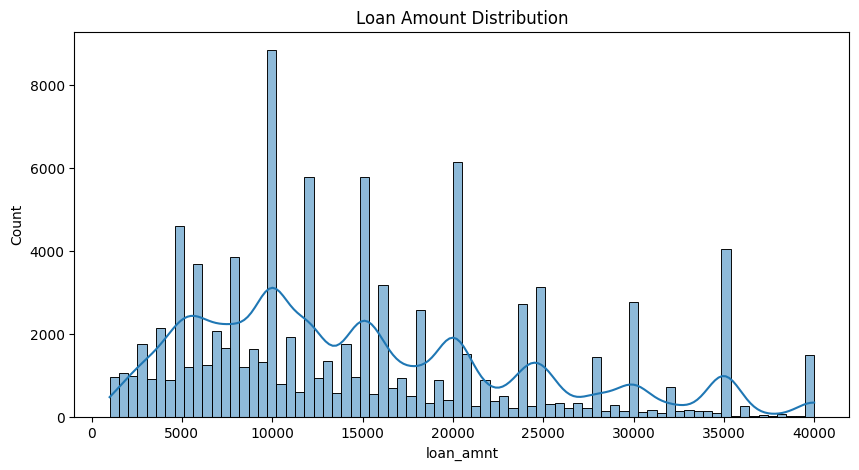

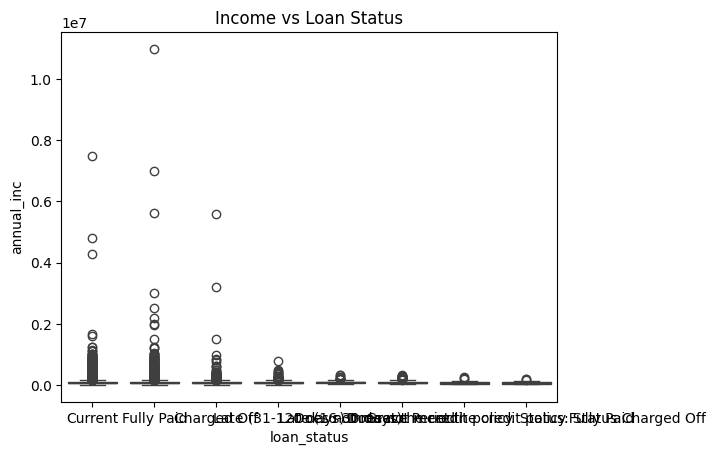

In [4]:
# Visualizations
plt.figure(figsize=(10, 5))
sns.histplot(df['loan_amnt'], kde=True)
plt.title('Loan Amount Distribution')
plt.show()

sns.boxplot(x='loan_status', y='annual_inc', data=df)
plt.title('Income vs Loan Status')
plt.show()

In [5]:

# Drop columns with >50% missing
missing_perc = df.isnull().mean()
cols_to_drop = missing_perc[missing_perc > 0.5].index
df = df.drop(columns=cols_to_drop)

# Task 1.2: Feature Selection (predictive of default; based on dataset columns)
selected_features = [
    'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
    'home_ownership', 'annual_inc', 'verification_status', 'purpose',
    'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc'
]
# Ensure only existing columns are selected
selected_features = [col for col in selected_features if col in df.columns]
df = df[selected_features + ['loan_status']]

# Task 1.3: Data Cleaning
# Convert emp_length if present
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)

# Impute missing: numeric median, categorical mode
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns.drop('loan_status', errors='ignore')

imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encode categorical
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out())

# Scale numeric
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[num_cols])
num_scaled_df = pd.DataFrame(num_scaled, columns=num_cols)

# Combine
df_processed = pd.concat([num_scaled_df, cat_encoded_df], axis=1)

# Binary target: 1 = Defaulted (Charged Off/Default), 0 = Fully Paid
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)
y = df['loan_status'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Train shape:", X_train.shape)

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-4281368483.py:20: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)


Preprocessing complete. Train shape: (80000, 79)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, f1_score

# Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# MLP Model
class LoanClassifier(nn.Module):
    def __init__(self, input_size):
        super(LoanClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = LoanClassifier(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
epochs = 10
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate
model.eval()
preds = []
with torch.no_grad():
    for data, _ in test_loader:
        output = model(data)
        preds.extend(output.cpu().numpy())

auc = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, (np.array(preds) > 0.5).astype(int))
print(f"AUC: {auc:.4f}, F1-Score: {f1:.4f}")


Epoch 1, Loss: 0.3430933356285095
Epoch 2, Loss: 0.33975350856781006
Epoch 3, Loss: 0.29850661754608154
Epoch 4, Loss: 0.3368539810180664
Epoch 5, Loss: 0.1861746907234192
Epoch 6, Loss: 0.47786036133766174
Epoch 7, Loss: 0.3076387941837311
Epoch 8, Loss: 0.27246007323265076
Epoch 9, Loss: 0.37506434321403503
Epoch 10, Loss: 0.21969105303287506
AUC: 0.7116, F1-Score: 0.0591


In [8]:
!pip install d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827724 sha256=d40d9f0dceee8b10f13a2a17819065af6f2f1cc24a8b7895e247853c1f5ec74c
  Stored in directory: /root/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
  Attempting uninstall: gy

In [20]:
import d3rlpy
from d3rlpy.metrics import AverageValueEstimationEvaluator


# Prepare RL data
df_rl = df.copy()
df_rl['action'] = 1  # All approved
df_rl['reward'] = np.where(
    df_rl['loan_status'] == 0,  # Fully Paid
    df_rl['loan_amnt'] * (df_rl['int_rate'] / 100),  # Profit
    -df_rl['loan_amnt']  # Loss
)

# Simulate denies (duplicate with action=0, reward=0)
df_deny = df_rl.copy()
df_deny['action'] = 0
df_deny['reward'] = 0
df_rl = pd.concat([df_rl, df_deny])

# Combine/duplicate the processed features the same way as you duplicated df_rl
states = pd.concat([df_processed, df_processed]).values
actions = df_rl['action'].values
rewards = df_rl['reward'].values
terminals = np.ones(len(df_rl))


# MDPDataset
dataset = d3rlpy.dataset.MDPDataset(
    observations=states.astype(np.float32),
    actions=actions.astype(np.int64),
    rewards=rewards.astype(np.float32),
    terminals=terminals.astype(np.float32)
)

# Train CQL (offline RL)
#cql = d3rlpy.algos.CQLConfig().create(device='cuda:0' if torch.cuda.is_available() else 'cpu')
#cql.fit(dataset, n_steps=10000)
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0' if torch.cuda.is_available() else 'cpu')
cql.fit(dataset, n_steps=10000)


# Policy value (average reward)

# Create an evaluator instance
evaluator = AverageValueEstimationEvaluator()

# Evaluate your trained policy on the dataset
policy_value = evaluator(cql, dataset)
print("Estimated Policy Value:", policy_value)



2025-09-15 09:09.40 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(79,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-09-15 09:09.40 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-09-15 09:09.40 [info     ] Action size has been automatically determined. action_size=2
2025-09-15 09:09.41 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(79,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-09-15 09:09.41 [debug    ] Building models...            
2025-09-15 09:09.41 [debug    ] Models have been built.       
2025-09-15 09:09.41 [info  

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-09-15 09:10.39 [info     ] DiscreteCQL_20250915090941: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007854812622070312, 'time_algorithm_update': 0.0047728666067123416, 'loss': 1800.9061777496338, 'td_loss': 1799.662091609192, 'conservative_loss': 1.2440863682746888, 'time_step': 0.0057168694019317625} step=10000
2025-09-15 09:10.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250915090941/model_10000.d3
Estimated Policy Value: 3.188516644643545
